✨ This notebook can run on a small Nvidia Tesla T4 Instance, for example using the **free** T4 Google Colab instance. To run on Colab, select **Runtime** followed by **Change Runtime type**, select **T4 GPU**. Next, select **Runtime** followed by **Run all**.

This notebook demonstrates how to:

- Fine-tune a TinyLlama model using QLoRA technique
- Optimize the model for inferencing with the [ONNX Runtime](https://onnxruntime.ai/), a cross-platform machine-learning model accelerator, with a flexible interface to integrate hardware-specific libraries.
- Save the base model and adapters seperately for multi-LoRA model serving with ONNX Runtime
- Run the model using the ONNX Runtime


In [ ]:
%%capture

# Install dependencies
!pip install git+https://github.com/microsoft/Olive
!pip install transformers accelerate bitsandbytes datasets trl protobuf einops peft numpy optimum onnxruntime-gpu flash-attn
!pip install onnxruntime-genai-cuda --index-url=https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
!sudo apt-get -y install cudnn9-cuda-12

## The data

In this example, you'll be fine-tuning a language model to classify phrases into one of joy/surprise/fear/sadness categories. The dataset, which is available on Hugging Face, is show below.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("xxyyzzz/phrase_classification")
dataset['train'].to_pandas().head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1464 [00:00<?, ? examples/s]

,phrase,tone
0,I'm thrilled to start my new job!,joy
1,I can't believe I lost my keys again.,surprise
2,This haunted house is terrifying!,fear
3,Winning the lottery is a dream come true.,joy
4,Missing the concert is really disappointing.,sadness


## Train the model

Next, the `olive finetune` command executes. This single command will not only fine-tune the model but also optimize the model to run with quality and performance on the [ONNX runtime](https://onnxruntime.ai/).

🧠 Olive supports the following models out-of-the-box: Phi, Llama, Mistral, Gemma, Qwen, Falcon and [many others](https://huggingface.co/docs/optimum/en/exporters/onnx/overview).

☕ It can take around 20-30mins for the finetuning and optimization to complete. At the end of the process you will have an optimized ONNX model and adapter.

⚙️ For more information on available options, read the [Olive Finetune documentation](https://microsoft.github.io/Olive/features/cli.html#finetune).

In [ ]:
%%shell

# Hugging Face model name (repo/model)
MODEL="TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# Some other options for models (not exhaustive)
# MODEL="microsoft/Phi-3.5-mini-instruct"
# MODEL="microsoft/meta-llama/Meta-Llama-3.1-8B-Instruct"
# MODEL="Qwen/Qwen2-VL-2B-Instruct"

# Set the prompt format for TinyLlama
PROMPT_FORMAT="<|user|>\n{phrase}</s>\n<|assistant|>\n{tone}</s>"
# Prompt formats for other models
# PROMPT_FORMAT="<|user|>\n{phrase}<|end|>\n<|assistant|>\n{tone}<|end|>" # Phi
# PROMPT_FORMAT="<|start_header_id|>user<|end_header_id|>{phrase}<|eot_id|><|start_header_id|>assistant<|end_header_id|>{tone}<|end_of_text|>" # Llama 3

# Number of steps to fine-tune for
MAX_STEPS=50

# Execute the finetune command - this will also run optimization and adapter extraction.
olive finetune \
    --method qlora \
    --model_name_or_path $MODEL \
    --trust_remote_code \
    --use_ort_genai \
    --data_name xxyyzzz/phrase_classification \
    --text_template $PROMPT_FORMAT \
    --max_steps $MAX_STEPS

[2024-09-03 11:14:46,433] [INFO] [config.py:252:validate_evaluate_input_model] No evaluator is specified, skip to evaluate model
[2024-09-03 11:14:46,434] [INFO] [run.py:138:run_engine] Running workflow default_workflow
[2024-09-03 11:14:46,455] [INFO] [cache.py:51:__init__] Using cache directory: /content/.olive-cache/default_workflow
[2024-09-03 11:14:46,458] [INFO] [engine.py:1012:save_olive_config] Saved Olive config to /content/.olive-cache/default_workflow/olive_config.json
[2024-09-03 11:14:46,466] [INFO] [accelerator_creator.py:224:create_accelerators] Running workflow on accelerator specs: gpu-cuda
[2024-09-03 11:14:46,482] [INFO] [engine.py:275:run] Running Olive on accelerator: gpu-cuda
[2024-09-03 11:14:46,482] [INFO] [engine.py:1109:_create_system] Creating target system ...
[2024-09-03 11:14:46,482] [INFO] [engine.py:1112:_create_system] Target system created in 0.000143 seconds
[2024-09-03 11:14:46,482] [INFO] [engine.py:1121:_create_system] Creating host system ...
[202

📂 The output is located in a folder named `optimized-model`. Below is a list of the folder - notice the adapter weights are *separate* from the base model, and the weights are small (in comparison to the base model) at ~97MB.

In [8]:
%ls -lah optimized-model

total 2.2G
drwxr-xr-x 2 root root 4.0K Sep  3 12:00 ./
drwxr-xr-x 1 root root 4.0K Sep  3 12:00 ../
-rw-r--r-- 1 root root  97M Sep  3 11:51 adapter_weights.npz
-rw-r--r-- 1 root root  714 Sep  3 11:57 config.json
-rw-r--r-- 1 root root 1.6K Sep  3 12:00 genai_config.json
-rw-r--r-- 1 root root  216 Sep  3 11:57 generation_config.json
-rw-r--r-- 1 root root 1.3M Sep  3 11:57 model.onnx
-rw-r--r-- 1 root root 2.1G Sep  3 11:57 model.onnx.data
-rw-r--r-- 1 root root  551 Sep  3 11:57 special_tokens_map.json
-rw-r--r-- 1 root root 1.4K Sep  3 11:57 tokenizer_config.json
-rw-r--r-- 1 root root 1.8M Sep  3 11:57 tokenizer.json
-rw-r--r-- 1 root root 489K Sep  3 11:57 tokenizer.model


## Inference

🧪 The code below creates a test app that consumes the model in a simple console chat interface. You will be prompted to enter an input. Here are some phrases to try:

- "Cricket is a great game"
- "I was taken aback by the size of the whale"
- "there was concern about the dark lighting on the street"

🧑‍💻 Below we show the Python API for the ONNX Runtime. However, other language bindings are available in [Java, C#, C++](https://github.com/microsoft/onnxruntime-genai/tree/main/examples).

🚪To exit the chat interface, enter `exit` or select `Ctrl+c`.

You'll notice in the code that the base model is *loaded once* and the LoRA adapters are loaded separately, which is called *multi-loRA serving*. The diagram below articulates the inference efficiency of the multi-LoRA approach over merging the adapter with the base model and serving many times.

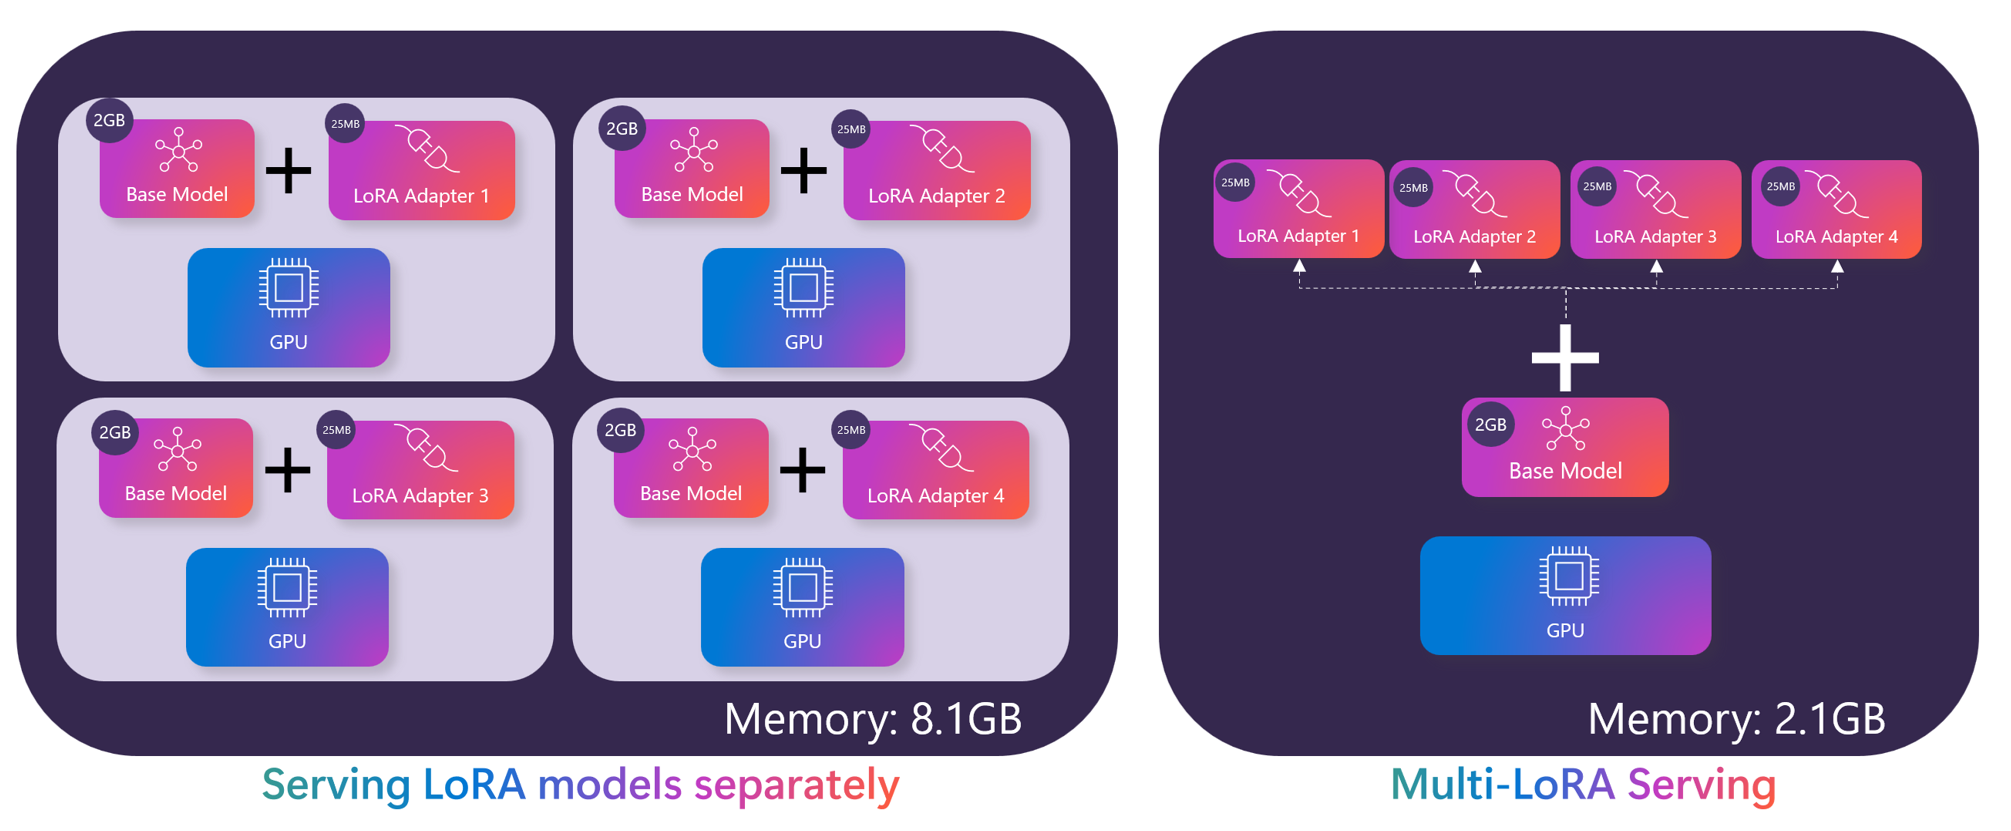

In [12]:
import onnxruntime_genai as og
import numpy as np
import os

model_folder = "optimized-model"

# Load the base model and tokenizer
model = og.Model(model_folder)
tokenizer = og.Tokenizer(model)
tokenizer_stream = tokenizer.create_stream()

# Load the LoRA adapter weights
weights_file = os.path.join(model_folder, "adapter_weights.npz")
adapter_weights = np.load(weights_file)

# Set the max length to something sensible by default,
# since otherwise it will be set to the entire context length
search_options = {}
search_options['max_length'] = 200
search_options['past_present_share_buffer'] = False

chat_template = "<|user|>\n{input}</s>\n<|assistant|>"

text = input("Enter phrase: ")

# Keep asking for input phrases
while text != "exit":
  if not text:
    print("Error, input cannot be empty")
    exit

  # generate prompt (prompt template + input)
  prompt = f'{chat_template.format(input=text)}'

  # encode the prompt using the tokenizer
  input_tokens = tokenizer.encode(prompt)

  # the adapter weights are added to the model at inference time. This means you
  # can select different adapters for different tasks i.e. multi-LoRA.

  params = og.GeneratorParams(model)
  for key in adapter_weights.keys():
      params.set_model_input(key, adapter_weights[key])
  params.set_search_options(**search_options)
  params.input_ids = input_tokens
  generator = og.Generator(model, params)

  print("Output: ", end='', flush=True)
  # stream the output
  try:
    while not generator.is_done():
      generator.compute_logits()
      generator.generate_next_token()

      new_token = generator.get_next_tokens()[0]
      print(tokenizer_stream.decode(new_token), end='', flush=True)
  except KeyboardInterrupt:
      print("  --control+c pressed, aborting generation--")

  print()
  text = input("Input: ")

# delete the objects to free up resources.
del generator
del model
del tokenizer
del tokenizer_stream

Enter phrase: cricket is an amazing game!
Output: 
joy
Input: exit


## Publish to Hugging Face

🤗 You'll need to get a token from https://huggingface.co/settings/tokens.

In [14]:
%%shell

# update these parameters
TOKEN="" # get a token from https://huggingface.co/settings/tokens
REPO_ID="" # for example username/repo-name
MODEL_PATH="optimized-model" # no need to change

huggingface-cli upload --token $TOKEN $REPO_ID $MODEL_PATH

usage: huggingface-cli <command> [<args>] upload [-h] [--repo-type {model,dataset,space}]
                                                 [--revision REVISION] [--private]
                                                 [--include [INCLUDE ...]]
                                                 [--exclude [EXCLUDE ...]] [--delete [DELETE ...]]
                                                 [--commit-message COMMIT_MESSAGE]
                                                 [--commit-description COMMIT_DESCRIPTION]
                                                 [--create-pr] [--every EVERY] [--token TOKEN]
                                                 [--quiet]
                                                 repo_id [local_path] [path_in_repo]

positional arguments:
  repo_id               The ID of the repo to upload to (e.g. `username/repo-name`).
  local_path            Local path to the file or folder to upload. Defaults to current directory.
  path_in_repo          Path of t